# Master Time Features
## _Unencoding_ vs _Cyclical Encoding_ vs _Dummy Encoding_

Part of the following code comes from: https://www.kaggle.com/avanwyk/encoding-cyclical-features-for-deep-learning


In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [83]:
data = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv',
                   parse_dates=['Date'])

In [84]:
data.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [85]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
Date    3650 non-null datetime64[ns]
Temp    3650 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 57.2 KB


In [86]:
data.describe()

,Temp
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


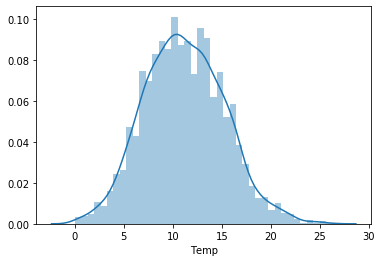

In [87]:
plt.figure()
sns.distplot(data['Temp'], bins=40)
plt.show()

In [88]:
data['day_of_week'] = data['Date'].dt.dayofweek
data['day_of_month'] = data['Date'].dt.day
data['month'] = data['Date'].dt.month

In [89]:
data.head()

,Date,Temp,day_of_week,day_of_month,month
0,1981-01-01,20.7,3,1,1
1,1981-01-02,17.9,4,2,1
2,1981-01-03,18.8,5,3,1
3,1981-01-04,14.6,6,4,1
4,1981-01-05,15.8,0,5,1


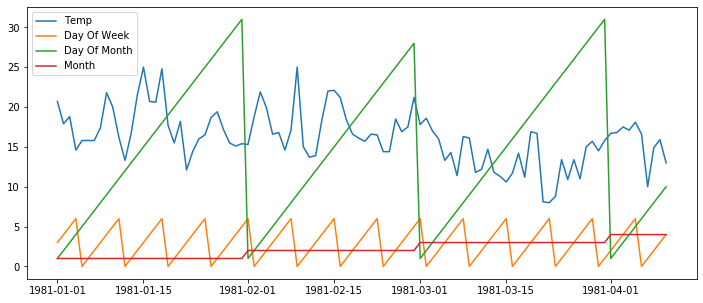

In [90]:
subdata = data[:100]
plt.figure(figsize=(12,5))
plt.plot(subdata['Date'], subdata['Temp'], label='Temp')
plt.plot(subdata['Date'], subdata['day_of_week'], label='Day Of Week')
plt.plot(subdata['Date'], subdata['day_of_month'], label='Day Of Month')
plt.plot(subdata['Date'], subdata['month'], label='Month')
plt.legend()
plt.show()

In [91]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras_tqdm import TQDMNotebookCallback

In [99]:
def build_model(input_size):
    tf.keras.backend.clear_session()
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=10, activation='selu', kernel_initializer='lecun_normal', input_shape=(input_size,)))
    model.add(tf.keras.layers.Dense(units=3, activation='selu', kernel_initializer='lecun_normal'))
    model.add(tf.keras.layers.AlphaDropout(0.2))
    model.add(tf.keras.layers.Dense(units=1))
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam()) 
    return model

def train_model(x_train, y_train, x_val, y_val):
    model = build_model(x_train.shape[1])
    history = model.fit(x_train, y_train, epochs=50, batch_size=8, validation_data=(x_val, y_val), verbose=0, 
                        callbacks=[TQDMNotebookCallback(), 
                                   tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
                                   tf.keras.callbacks.ReduceLROnPlateau(patience=5)])
    return model, history

def eval_model(x_train, y_train, x_val, y_val, x_test, y_test, view=True):
    model, history = train_model(x_train, y_train, x_val, y_val)    
    if view:
        plt.figure()
        plt.plot(history.epoch, history.history['loss'], label='loss')
        plt.plot(history.epoch, history.history['val_loss'], label='val_loss')
        plt.legend()
        plt.show()
    print('Test MSE:', model.evaluate(x_test, y_test, batch_size=8, verbose=0))
    return

In [100]:
from sklearn.model_selection import train_test_split

def get_data(data, features, target):
    x = data[features].values
    y = data[target].values

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, shuffle=False)
    x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, shuffle=False)

    print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)
    
    scaler = MinMaxScaler(feature_range=(-1,1))
    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)
    x_test = scaler.transform(x_test)
    
    return x_train, y_train, x_val, y_val, x_test, y_test

### Unencoded features

(2190, 3) (2190,) (730, 3) (730,) (730, 3) (730,)


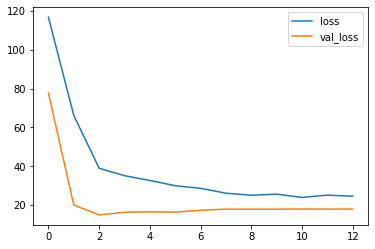

Test MSE: 16.894364848202223


In [101]:
x_train, y_train, x_val, y_val, x_test, y_test = get_data(data=data, 
                                                          features=['day_of_week','day_of_month','month'], 
                                                          target='Temp')
eval_model(x_train, y_train, x_val, y_val, x_test, y_test)

### Cyclical feature encoding

In [102]:
def cyclode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

data = cyclode(data, 'day_of_week', data['day_of_week'].max())
data = cyclode(data, 'day_of_month', data['day_of_month'].max())
data = cyclode(data, 'month', data['month'].max())

(2190, 6) (2190,) (730, 6) (730,) (730, 6) (730,)


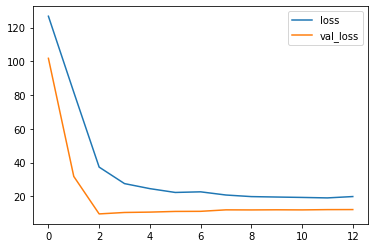

Test MSE: 9.93186671635876


In [103]:
x_train, y_train, x_val, y_val, x_test, y_test = get_data(data=data, 
                                                          features=['day_of_week_sin','day_of_week_cos',
                                                                    'day_of_month_sin','day_of_month_cos',
                                                                    'month_sin','month_cos'], 
                                                          target='Temp')
eval_model(x_train, y_train, x_val, y_val, x_test, y_test)

### Dummy feature encoding

In [104]:
def dumcode(data, col):
    dummies = pd.get_dummies(data[col], prefix=col, drop_first=True)
    dumnames = list(dummies.columns)
    data = pd.concat([data, dummies], 1)
    return data, dumnames

features = []
data, dumnames = dumcode(data, 'day_of_week')
features.extend(dumnames)
data, dumnames = dumcode(data, 'day_of_month')
features.extend(dumnames)
data, dumnames = dumcode(data, 'month')
features.extend(dumnames)

(2190, 94) (2190,) (730, 94) (730,) (730, 94) (730,)


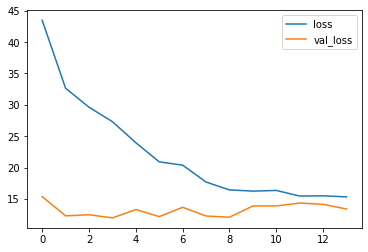

Test MSE: 11.359471854118452


In [105]:
x_train, y_train, x_val, y_val, x_test, y_test = get_data(data, features, 'Temp')
eval_model(x_train, y_train, x_val, y_val, x_test, y_test)